# Applying an impact model for hydroelectric dam management driven bya time series of runoff data
# Author: 2020, John Methven
### Adaptation to Jupyter notebook, 2021: Judith Berner

In [9]:
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
import numpy as np
from scipy import optimize
from scipy import signal
from netCDF4 import Dataset
import datetime
from datetime import date
from datetime import timedelta
import readera_runoff_series as re
import utils
# from utils import damop_model, running_mean, plot_series 

### Can be run with CMIP6 2019.10 kernel

 ###   Implementation of the dam operation model of Hirsch et al (2014) 
 ###   This is called as a function from the main code

 ####   Input: 
 ####   :runoffarr  - input time series for runoff data
 ####   :dt         - runoff accumulation interval per record
 ####   :catcharea  - catchment area for the dam
 ####   :kappa      - parameter relating reservoir depth to volume
 ####   :hmax       - maximum water head (constraint on optimization)
 ####   :hmin       - minimum water head
 ####   :wmax       - maximum flow rate through turbines
 ####   :wmin       - minimum flow rate to maintain some power generation
 ####   :rmax       - maximum relief flow rate, bypassing turbines in flood
 ####   :sigma      - operational efficiency of power generation by dam
 ####   Output: 
 ####   :inflow     - input time series for inflow to reservoir  
 ####   :x          - output time series for water head at dam
 ####   :w          - output solution for optimum flow rate through turbines
 ####   :r          - output solution for relief flow rate
 ####   :gout       - value of time integrated generation for optimum solution (MW-days)


## Main program script for controlling the hydroelectric dam management model and its output

#### First set parameters 

In [10]:
    #
    # Set the parameters for the geometry of the chosen dam
    #
    hdam = 161.            # dam height (m)
    catcharea = 254.5*1.e6 # dam catchment area converted to m^2
    area = 13*1.e6         # reservoir area converted to m^2
    #
    # Assuming max reservoir depth equals dam height.
    # Also assuming that average reservoir depth is a fraction of the max depth.
    #
    max_volume = area*hdam*0.5
    kappa = max_volume/hdam
    maxflow = 100.           # stated maximum flow through hydro turbines (m^3 s^-1)
    maxpower = 153.          # stated maximum power generation by plant (MW)
    taudam = 180.            # timescale for dam to run dry at maximum flow rate (days)
    taudam = taudam*3600*24  # convert from days to seconds
    #
    # Set the constraints on the optimization for maximum power generation
    #
    hmax = 0.5*hdam
    hmin = 0.2*hmax
    wmax = (kappa/taudam)*hdam
    # NOTE: model uses either maxflow OR taudam to constrain flow rates (but not both)
    # wmax = maxflow
    beta = 0.1               # where min(flow rate) = beta*max(flow rate) 
    wmin = beta*wmax
    rmax = 0.2*wmax          # maximum relief flow diverting around turbines
    sigma = 0.9              # operational efficiency factor for the power station
    mu = maxpower/(sigma*wmax*hmax) # conversion factor to GW for power generation estimate
    #
    # Pick the location of the dam to extract the time series
    #
    lonpick = 136.502
    latpick = 35.667
    dlon = 0.1 # runoff data grid box side in degrees longitude
    dlat = 0.1 # runoff data grid box side in degrees latitude
    radea = 6371000. # average radius of the Earth (m)
    boxarea = dlon*(np.pi/180)*dlat*(np.pi/180)*np.cos(latpick*np.pi/180)*radea*radea
    #
    # Select the start and end date required for the time series
    #
    dstart = datetime.date(2018, 6, 1)
    dend = datetime.date(2018, 7, 31)


In [11]:
    #
    # Set the path and filename stem for ERA5 data files.   
    #
    fpath = '/glade/u/home/berner/ASP2021_tutorials/hydro/data/ERA5/japan/'
    fstem = 'japan_ERA5land.'


#
### Call the function to extract the run-off time series
#

Read data for accumulation to  2018-06-02 00:00:00

Longitude of nearest grid box =  136.6
Latitude of nearest grid box =  35.6


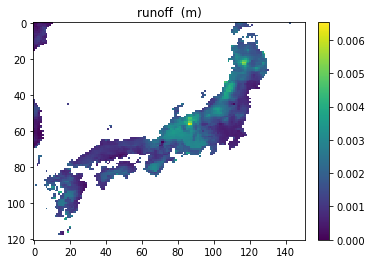

Read data for accumulation to  2018-06-02 00:00:00
Read data for accumulation to  2018-06-03 00:00:00
Read data for accumulation to  2018-06-04 00:00:00
Read data for accumulation to  2018-06-05 00:00:00
Read data for accumulation to  2018-06-06 00:00:00
Read data for accumulation to  2018-06-07 00:00:00
Read data for accumulation to  2018-06-08 00:00:00
Read data for accumulation to  2018-06-09 00:00:00
Read data for accumulation to  2018-06-10 00:00:00
Read data for accumulation to  2018-06-11 00:00:00
Read data for accumulation to  2018-06-12 00:00:00
Read data for accumulation to  2018-06-13 00:00:00
Read data for accumulation to  2018-06-14 00:00:00
Read data for accumulation to  2018-06-15 00:00:00
Read data for accumulation to  2018-06-16 00:00:00
Read data for accumulation to  2018-06-17 00:00:00
Read data for accumulation to  2018-06-18 00:00:00
Read data for accumulation to  2018-06-19 00:00:00
Read data for accumulation to  2018-06-20 00:00:00
Read data for accumulation to  

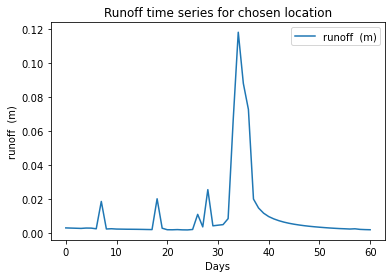

In [12]:
    dayarr, timarr, runoffarr = re.extract_series(fpath, fstem, lonpick, latpick, dstart, dend)
    dt = dayarr[1]-dayarr[0] # interval between data records (days)
    dt = dt*3600*24          # convert from days to seconds
    n = len(dayarr)

In [13]:
dayarr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [14]:
runoffarr

array([0.00321496, 0.00311675, 0.00301984, 0.00292577, 0.00312949,
       0.00309726, 0.00269532, 0.01878645, 0.00258483, 0.00273015,
       0.00253863, 0.00248891, 0.00243569, 0.00241531, 0.00238644,
       0.00233987, 0.00228008, 0.00223066, 0.02035871, 0.00303682,
       0.00214516, 0.00211597, 0.00222033, 0.0020718 , 0.0020356 ,
       0.00229047, 0.01118659, 0.00381644, 0.02572839, 0.00444457,
       0.00480744, 0.00514876, 0.00867518, 0.06666296, 0.11832284,
       0.08822031, 0.07290565, 0.02019612, 0.01492115, 0.01187596,
       0.0098861 , 0.00852704, 0.00746773, 0.00662083, 0.00594417,
       0.00538902, 0.00492594, 0.00452534, 0.00418075, 0.00388939,
       0.00362866, 0.00339249, 0.00317601, 0.00298702, 0.00282084,
       0.00270395, 0.00255285, 0.00270027, 0.00234864, 0.00221841,
       0.00213782])

### Call the dam management model to return results for optimum power generation subject to constraints on reservoir level and flow rate through turbines.

In [15]:
    inflow, h, w, r, gout = utils.damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma)
    powergen = mu*sigma*w*h

    ilabel = 'inflow  (m^3 s^-1)'
    hlabel = 'head   (m)'
    wlabel = 'flow rate  (m^3 s^-1)'
    rlabel = 'relief flow  (m^3 s^-1)'
    plabel = 'generation rate  (MW)'
    mytitle = 'dam model optimisation output'


damop_model has been called with the constraints:
wmax =  67.29038065843622    wmin =  6.729038065843622    hmax =  80.5    hmin =  16.1
Now apply quadratic minimization technique
Iteration limit reached    (Exit mode 9)
            Current function value: -0.24658259834540827
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Constrained optimization
     fun: -0.24658259834540827
     jac: array([-8.12221559e-03, -8.07454053e-03,  5.46746109e-04,  2.82289911e-04,
        5.20803460e-04,  3.06261188e-04,  3.71648463e-04,  1.81624082e-04,
        3.57683156e-04,  3.33735364e-04,  4.96445653e-04,  3.52517776e-04,
        4.86309374e-04,  3.67179759e-04,  4.76648084e-04,  3.79561331e-04,
        4.69869681e-04,  2.39077105e-04,  2.86042707e-04,  2.37731891e-04,
        2.28134911e-04, -2.73859712e-05, -2.73172125e-05, -4.91209042e-05,
       -2.35282311e-05, -6.61456013e-05, -6.59676502e-05, -1.28752793e-04,
       -8.97535707e-05, -9

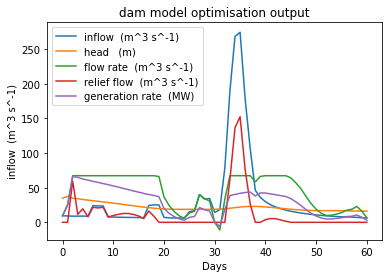

In [16]:
utils.plot_series(dayarr, inflow, h, w, r, powergen, ilabel, hlabel, wlabel, rlabel, plabel, mytitle)